[Forecasting: Principles and Practice](https://otexts.com/fpp2/)

In [1]:
from graph_traffic.get_data import get_data, ubs_index
from graph_traffic.dataloading import npzDataset
from graph_traffic.baseline_models import MeanRegressor, MedianRegressor, RepeatRegressor, RepeatLastRegressor, DaytimeRegressor, DriftRegressor
from graph_traffic.model_selection import timeseries_cv, plot_predictions
import numpy as np
from random import choices

data_dict = dict(
    ids_list=[3954, 3973, 3978],
    seq_len=12*4,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2019-12-31",
    dataset_name="small",
    target="intensidad",
    interactions=None
)

meteo_dict = dict(
    rain="drop",
    wind="drop",
    temperature="drop",
    humidity="drop",
    pressure="drop",
    radiation="drop"
)

temporal_dict = dict(
    year="drop",
    season="drop",
    month="drop",
    day_of_month="drop",
    weekday="drop",
    hour="passthrough",
    minute="drop",
    bank_holiday="drop",
    school_holiday="drop",
    working_day="passthrough"
)

get_data(data_dict, meteo_dict, temporal_dict)
dataset_name = data_dict["dataset_name"]
n_points = None

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = npzDataset(dataset_name, "train", n_points)
test_data = npzDataset(dataset_name, "test", n_points)

train_x = train_data.x
train_y = train_data.y

test_x = test_data.x
test_y = test_data.y

In [3]:
random_samples = choices(range(test_x.shape[0]), k=5)
random_samples

[1753, 4988, 3498, 4696, 4958]

# 1. Mean regressor

In [4]:
estimator, train_losses, test_losses = timeseries_cv(MeanRegressor(), train_x, train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 236.51, std: 5.00
Test MAE: 235.38, std: 17.39


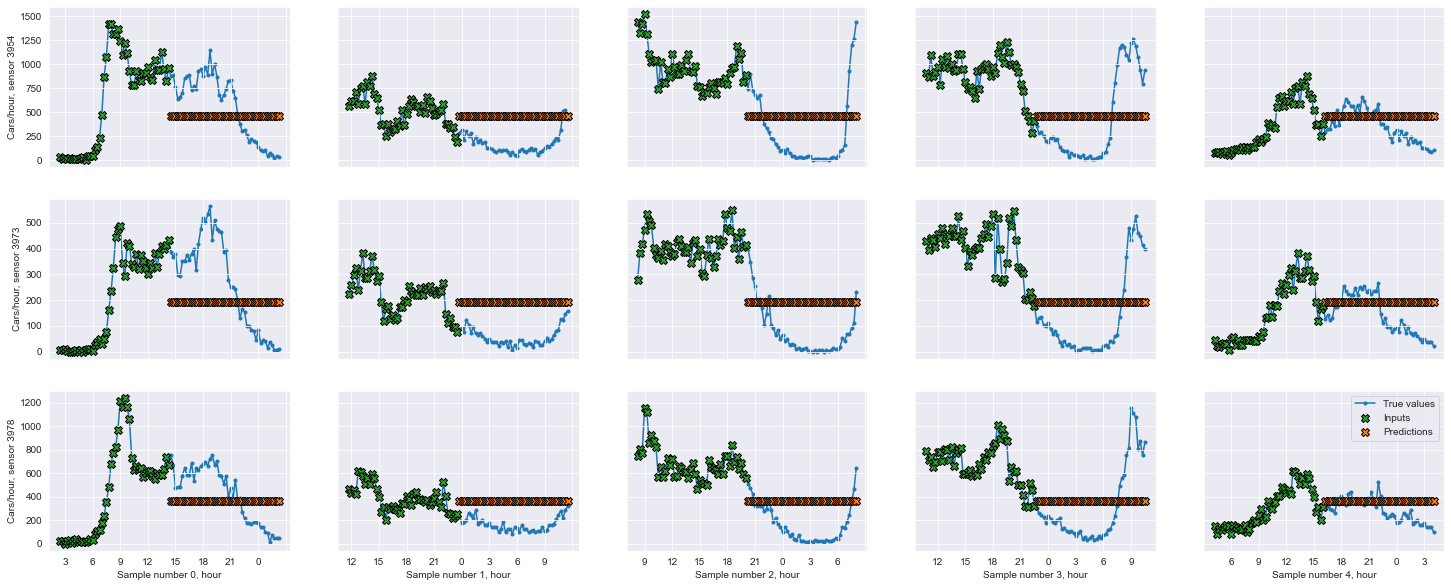

In [5]:
plot_predictions(estimator, test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])

# 2. Median regressor

In [6]:
estimator, train_losses, test_losses = timeseries_cv(MedianRegressor(), train_x, train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 234.37, std: 5.49
Test MAE: 231.13, std: 23.83


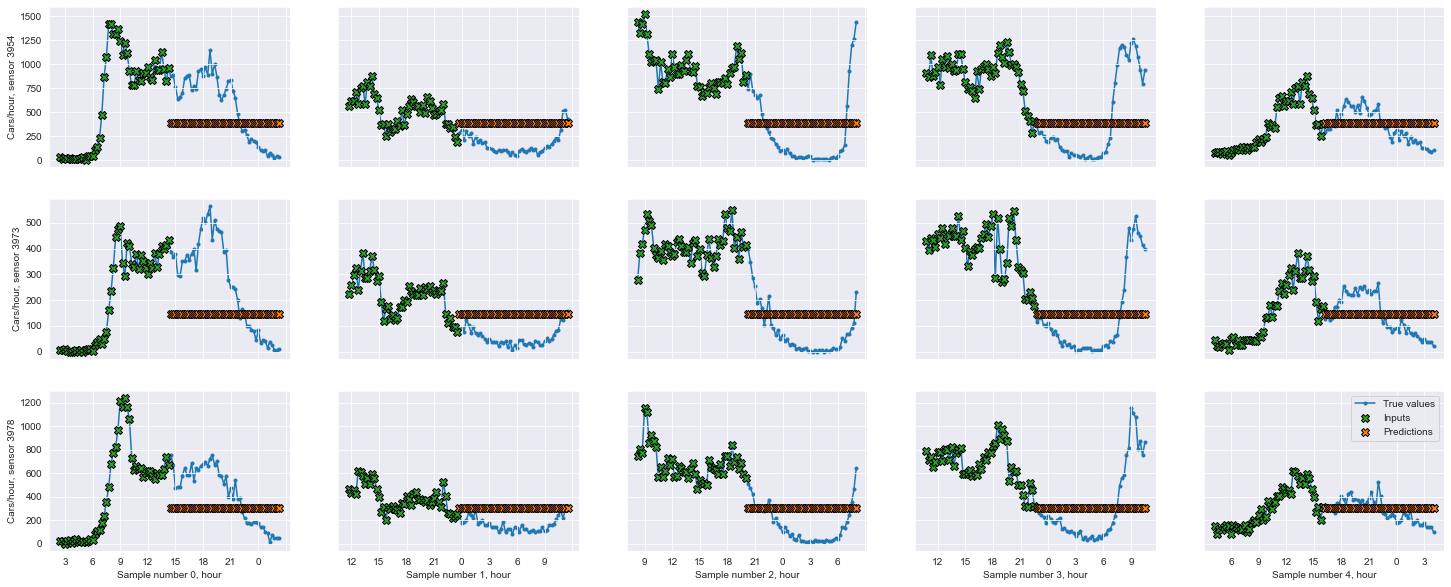

In [7]:
plot_predictions(estimator, test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])

# 3. Repeat regressor

In [8]:
estimator, train_losses, test_losses = timeseries_cv(RepeatRegressor(), train_x, train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 398.05, std: 11.85
Test MAE: 386.78, std: 51.17


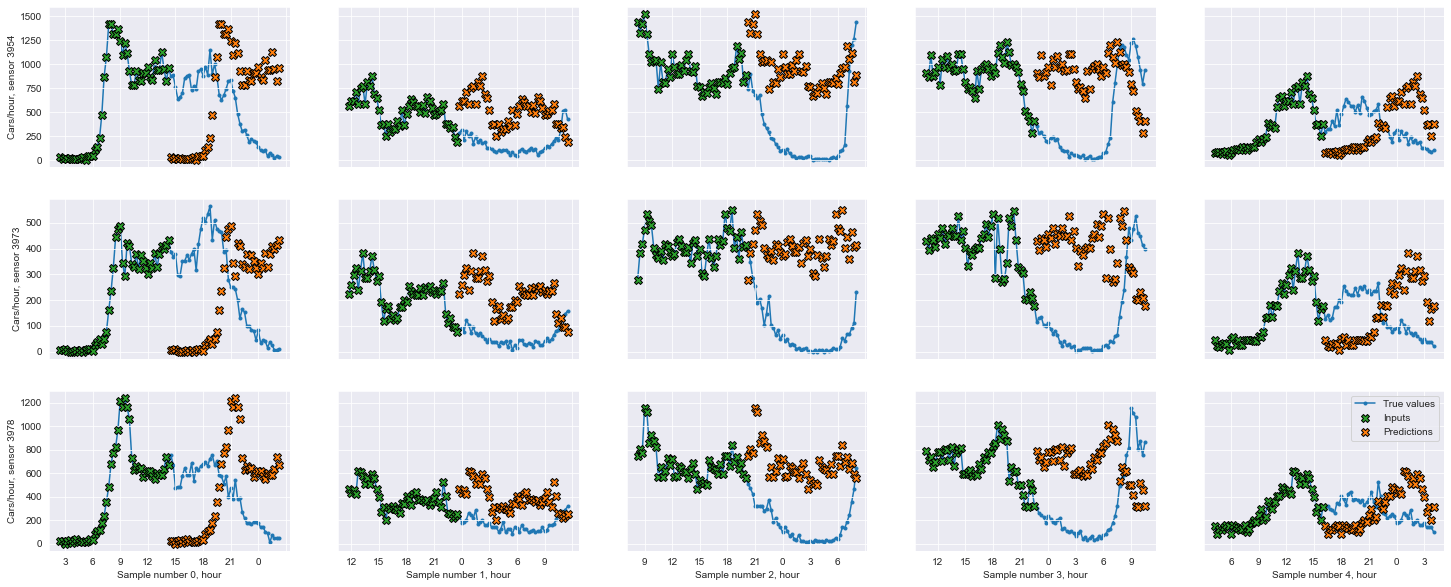

In [9]:
plot_predictions(estimator, test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])

# 4. Repeat last value regressor

In [10]:
estimator, train_losses, test_losses = timeseries_cv(RepeatLastRegressor(), train_x, train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 271.12, std: 8.51
Test MAE: 262.51, std: 35.03


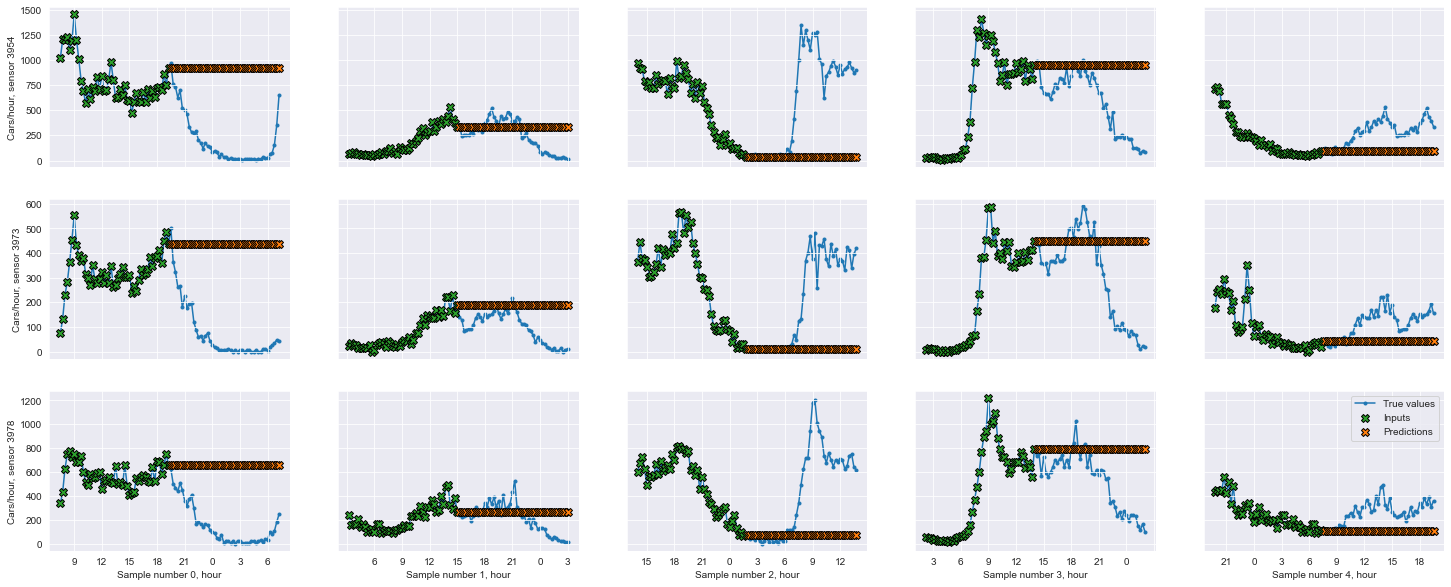

In [11]:
plot_predictions(estimator, train_x, train_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])

# 5. Mean per hour

In [12]:
estimator, train_losses, test_losses = timeseries_cv(DaytimeRegressor("mean"), train_x[:, :, :, [0, 1]], train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 163.27, std: 6.65
Test MAE: 164.85, std: 10.21


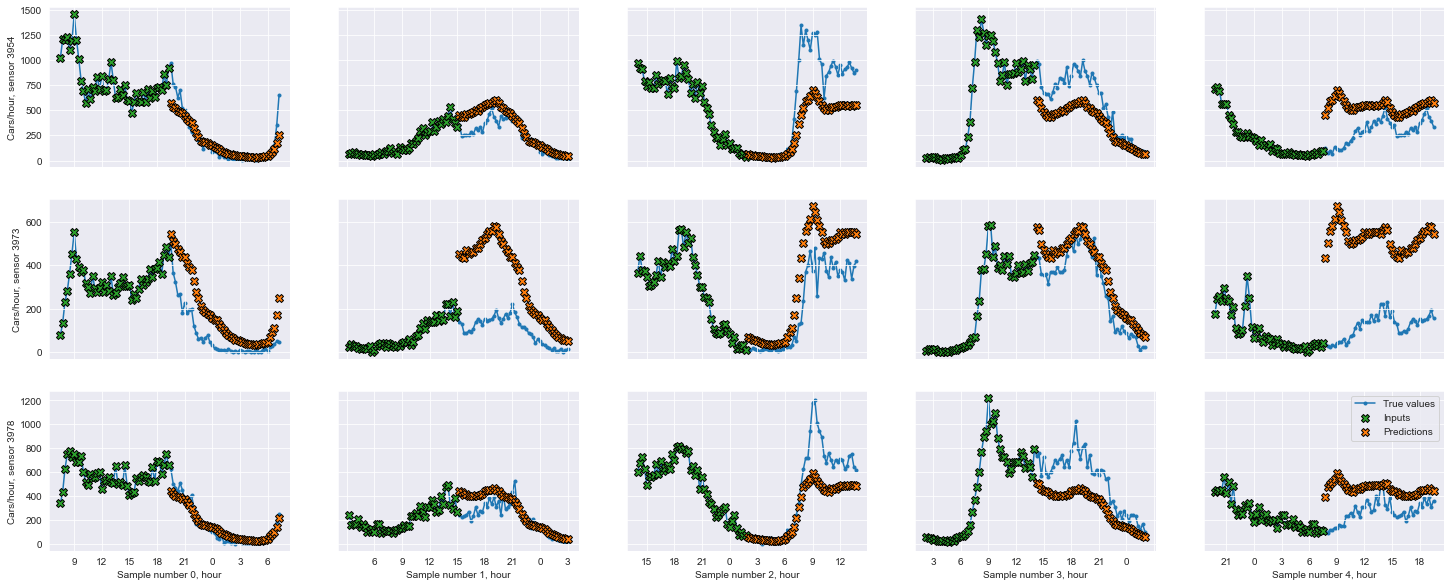

In [13]:
plot_predictions(estimator, train_x, train_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])

In [14]:
estimator, train_losses, test_losses = timeseries_cv(DaytimeRegressor("mean", by_working_day=True), train_x[:, :, :, [0, 1, 2]], train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 151.97, std: 6.28
Test MAE: 155.89, std: 6.06


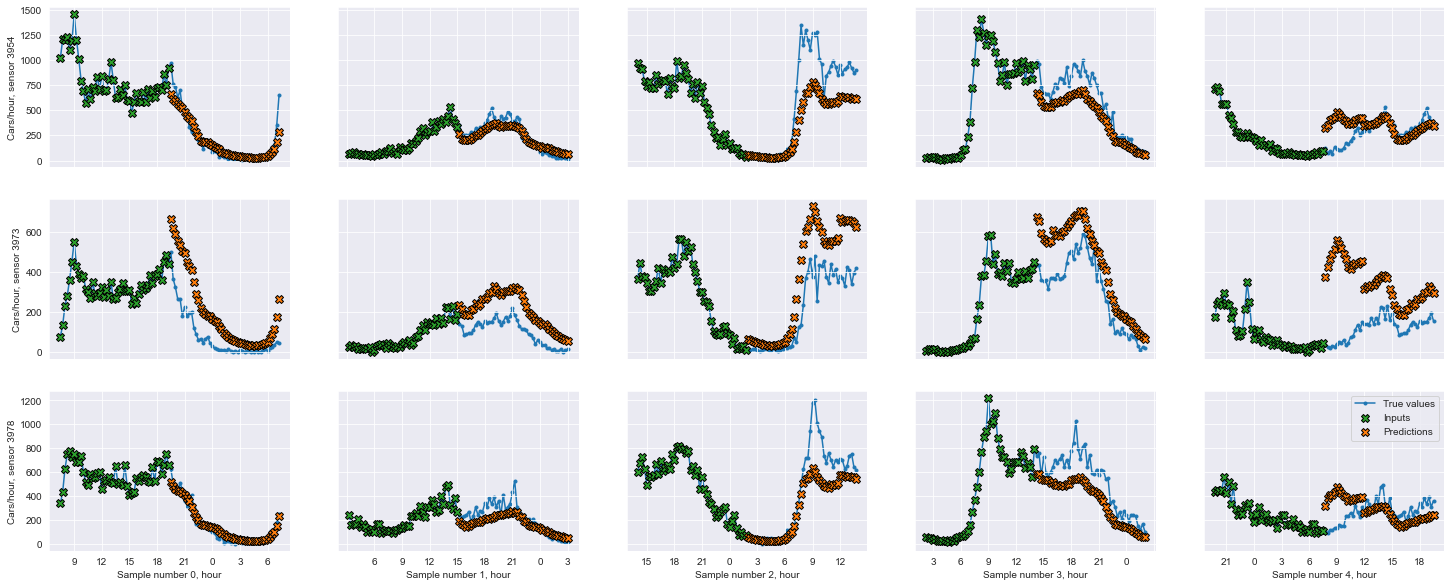

In [15]:
plot_predictions(estimator, train_x, train_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])

# 6. Median per hour

In [16]:
estimator, train_losses, test_losses = timeseries_cv(DaytimeRegressor("median"), train_x[:, :, :, [0, 1]], train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 162.38, std: 12.56
Test MAE: 163.68, std: 17.10


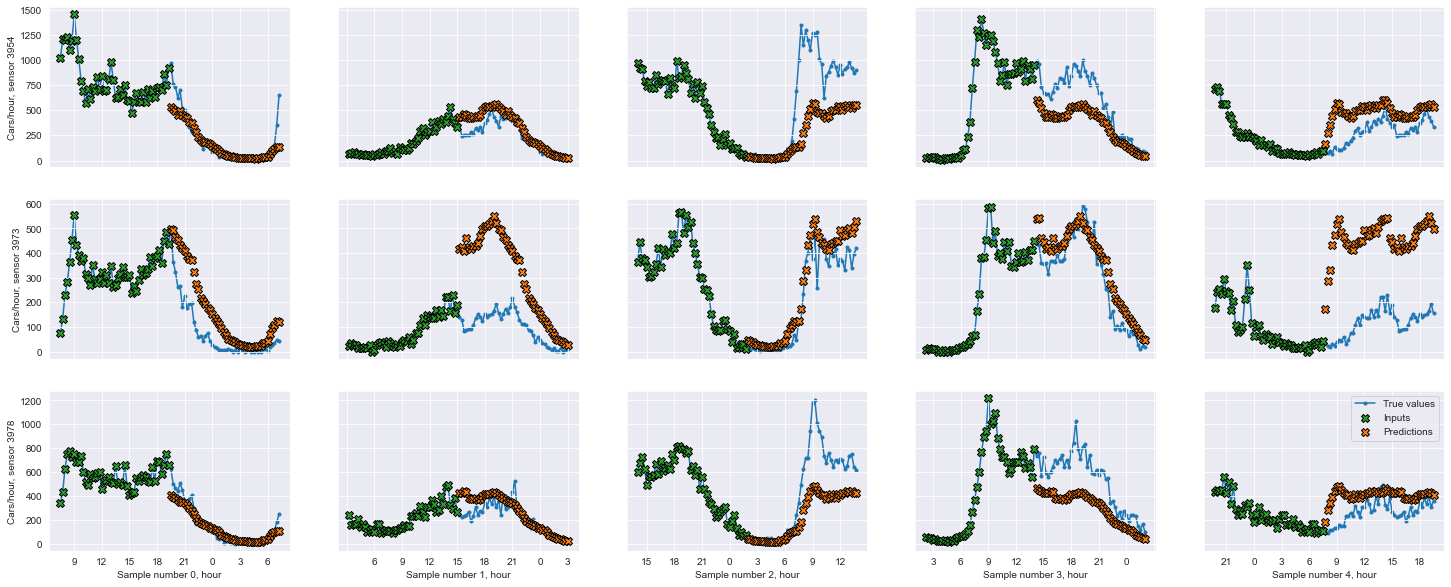

In [17]:
plot_predictions(estimator, train_x, train_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])

In [18]:
estimator, train_losses, test_losses = timeseries_cv(DaytimeRegressor("median", by_working_day=True), train_x[:, :, :, [0, 1, 2]], train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 150.74, std: 7.55
Test MAE: 155.65, std: 7.23


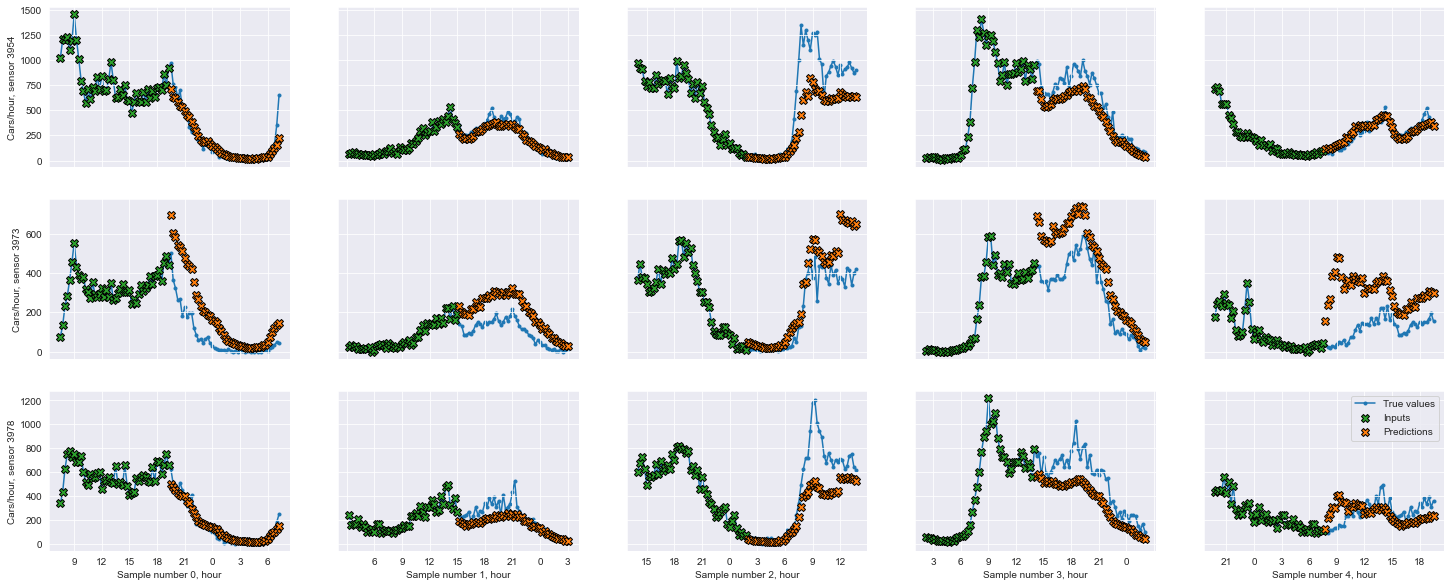

In [19]:
plot_predictions(estimator, train_x, train_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])

# 7. Drift regressor

In [20]:
estimator, train_losses, test_losses = timeseries_cv(DriftRegressor(), train_x, train_y)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 368.68, std: 10.69
Test MAE: 358.09, std: 45.90


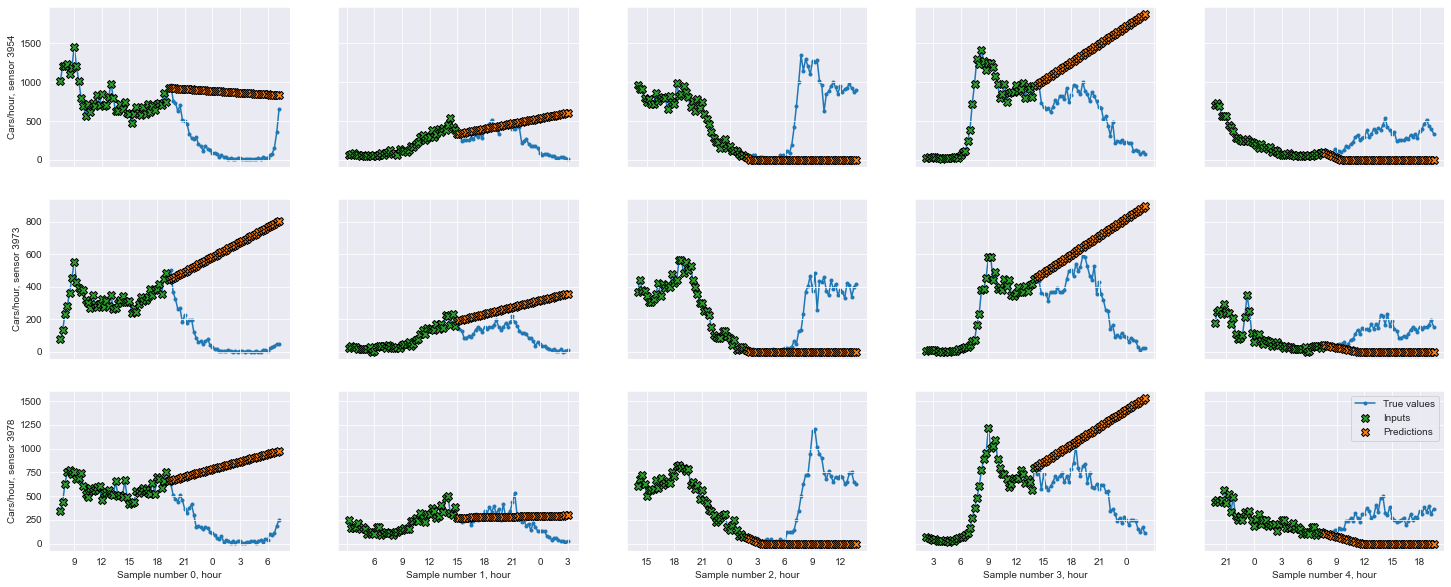

In [21]:
plot_predictions(estimator, train_x, train_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])